In [65]:
%load_ext autoreload
%autoreload 2

import datetime
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import casadi as cas
import pickle
import copy as cp

import argparse

PROJECT_PATH = '/home/nbuckman/Dropbox (MIT)/DRL/2020_01_cooperative_mpc/mpc-multiple-vehicles/'
sys.path.append(PROJECT_PATH)

import src.MPC_Casadi as mpc
import src.TrafficWorld as tw
import src.IterativeBestResponseMPCMultiple as mibr
import src.car_plotting_multiple as cmplot

np.set_printoptions(precision=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
x_e, y_e = 0,0
r = 1.5

In [84]:
x_o, y_o = 4,0
phi_o = 0.0 * np.pi/180

In [85]:
dx = x_o - x_e
dy = y_o - y_o

In [86]:
alpha = 4.3767
beta = 3.0267

In [87]:
R(phi_o)

array([[1., 0.],
       [0., 0.]])

In [88]:
def R(phi):
    return np.array([[np.cos(phi), 0],[0, np.sin(phi)]])

In [89]:
R_o = R(phi_o)

In [90]:
collision_free = (np.array([[dx],[dy]]).T @ R_o.T @ np.array([[1/alpha**2, 0],[0, 1/beta**2]]) @ R_o @ np.array([[dx],[dy]])) > 1

In [91]:
collision_free

array([[False]])

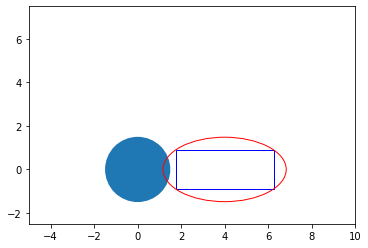

In [159]:
plt.plot(x_e, y_e)
c = patches.Circle((x_e, y_e), radius=r)
ax = plt.gca()
ax.axis('square')
ax.add_patch(c)
plt.xlim([-5, 10])
plt.ylim([-2.5, 7.5])

plt.plot(x_o, y_o)
a = 2.832
b = 1.4820


# a_val = 4.5
# b_val = 1.8
W = 1.8
L = 4.5
rec = patches.Rectangle((x_o-L/2, y_o-W/2), L, W, fill=None, edgecolor='blue')
ax.add_patch(rec)
a_val = 2.832
b_val = 1.4820
# a_val, b_val = 3.897114298575689, 1.1022703788869466
e = patches.Ellipse((x_o, y_o), 2*a_val, 2*b_val, fill=False, edgecolor='red')
ax.add_patch(e)

[[False]]


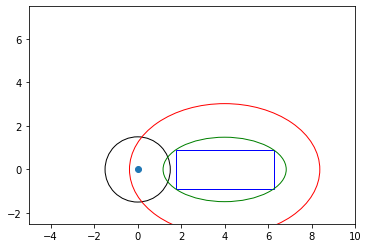

In [165]:
### Another way to see it as following
plt.plot(x_e, y_e,'o')
c = patches.Circle((x_e, y_e), radius=r, fill=None)
ax = plt.gca()
ax.axis('square')
ax.add_patch(c)
plt.xlim([-5, 10])
plt.ylim([-2.5, 7.5])

plt.plot(x_o, y_o)
a = 2.832
b = 1.4820


# a_val = 4.5
# b_val = 1.8
W = 1.8
L = 4.5
rec = patches.Rectangle((x_o-L/2, y_o-W/2), L, W, fill=None, edgecolor='blue')
ax.add_patch(rec)
a_val = 2.832
b_val = 1.4820

delta = 0.0447


# a_val, b_val = 3.897114298575689, 1.1022703788869466
e = patches.Ellipse((x_o, y_o), 2*(a_val), 2*(b_val), fill=False, edgecolor='green')
e_b = patches.Ellipse((x_o, y_o), 2*(a_val+delta+r), 2*(b_val+delta+r), fill=False, edgecolor='red')
ax.add_patch(e)
ax.add_patch(e_b)

collision_free = (np.array([[dx],[dy]]).T @ R_o.T @ np.array([[1/alpha**2, 0],[0, 1/beta**2]]) @ R_o @ np.array([[dx],[dy]])) > 1
print(collision_free)

array([[4.0, 0],
       [0, array([0.])]], dtype=object)

In [96]:
import casadi as cas

In [153]:
opti = cas.Opti()
a = opti.variable()
b = opti.variable()
opti.minimize(a*b**2)
opti.subject_to( ((L/2)**2/a**2 + (W/2)**2/b**2) <= 1)
opti.subject_to(a>0)
opti.subject_to(b>0)
opti.solver('ipopt')

In [154]:
opti.set_initial(a, 1)
opti.set_initial(b, 1.5)
solution = opti.solve()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        3
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [157]:
a_val = solution.value(a)
b_val = solution.value(b)
print(a_val, b_val)

3.897114298575689 1.1022703788869466


In [156]:
(L/2)**2/a_val**2 + (W/2)**2/b_val**2

1.0000000096471355

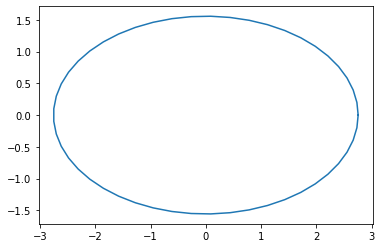

In [152]:
plt.plot([a_val*np.cos(t) for t in np.linspace(0, 2*np.pi, 50)], [b_val*np.sin(t) for t in np.linspace(0, 2*np.pi, 50)])

In [132]:
L

4.5

In [133]:
W

1.8

## From MATLAB

In [ ]:
clear all 
close all
clc 

%% 
W = 1.8;
L = 4.5;

min_elipse_box = @(a) (1 - L^2/(2*a)^2 - W^2/(2*a + W - L)^2) ;
a = fzero(min_elipse_box, 10)
b = a + 1/2*(W-L)
t = 0:.1:2*pi;
x = a*cos(t);
y = b*sin(t);
plot(x,y)
rectangle('Position',[-L/2 -W/2 L W])
axis('equal')
hold on
 
%% ellipsoid and circle dimensions
%a = 10; 
%b = 2; 
r = 1.5;
 
M = 400; 
dtheta = 2*pi / M; 
theta_M = (0 : dtheta : 2*pi)'; 


minimal_positive_root = @(delta) (2*(delta + r)^2*(2*a*b + a*(delta + r) + b*(delta + r)))/((a + b)*(a + b + 2*delta + 2*r))-r^2; 
x0 = 1.5; % initial guess must be always positive
delta = fzero(minimal_positive_root,x0)
disp(delta)
a_new = a+delta+r
b_new = b+delta+r

x = a_new*cos(t);
y = b_new*sin(t);
plot(x,y)

%%

for i = 1 : M+1 
    theta = theta_M(i); 
    
    %% ellipse coordinates
    x_M(i) = a * cos(theta); 
    y_M(i) = b * sin(theta); 
     
    alpha = a+delta+r; 
    beta = b+delta+r; 

    %% bounding ellipse
    
    x_1_M(i) = alpha * cos(theta); 
    y_1_M(i) = beta * sin(theta); 
    
    %% Minkowsky sum of ellipse (a,b) and circle r
    x_2_M(i) = a*cos(theta) + r*cos(theta)/(sqrt((cos(theta))^2 + (a^2/b^2)*(sin(theta))^2)); 
    y_2_M(i) = b*sin(theta) + r*sin(theta)/(sqrt((b^2/a^2)*(cos(theta))^2 + (sin(theta))^2));    
     

    %% previously used bounding ellipse
    a_3 = a + r; 
    b_3 = b + r; 
    x_3_M(i) = a_3 * cos(theta); 
    y_3_M(i) = b_3 * sin(theta); 
     
    %% circle coordinates
    x_4_M(i) = r * cos(theta); 
    y_4_M(i) = r * sin(theta); 
end 

h=figure; 
hold all; 
box on; 
grid on; 
axis equal; 
plot(x_M, y_M, '-r') 

plot(x_1_M, y_1_M, '-k') 
plot(x_2_M, y_2_M, '-b') 
plot(x_3_M, y_3_M, '-r')
legend("Ellipse","Minimal Bounding ellipse","Minkowski Sum","Bound Ellipse + Circle","Circle")
% legend(h,'off')
plot(x_4_M, y_4_M, '-g') 
% circle(0,0,a+r)


K = randi([floor(M/4/4), ceil(M/4/2)]); 
theta = theta_M(K); 
x = a * cos(theta); 
y = b * sin(theta); 
plot([0,x], [0, y], '-k') 
normal = r*[2*cos(theta)/a; 2*sin(theta)/b] / norm([2*cos(theta)/a; 2*sin(theta)/b]); 
plot([0, normal(1)], [0, normal(2)], '-b') 
plot([x, normal(1)+x], [y, normal(2)+y], '-b')
circle(normal(1)+x, normal(2)+y, r)
hold all
 
% theta_T = theta_M(1 : ceil(M/2)+1); 
% theta_T = theta_M; 
% delta_x_T = cos(theta_T) .* (r ./ (sqrt((cos(theta_T)).^2 + (a^2/b^2)*(sin(theta_T)).^2)) - 1); 
% delta_y_T = sin(theta_T) .* (r ./ (sqrt((b^2/a^2)*(cos(theta_T)).^2 + (sin(theta_T)).^2)) - 1); 
% figure; 
% hold all; 
% grid on; 
% box on; 
% plot(delta_x_T, '-k'); 
% plot(delta_y_T, '-r'); 
%  
% delta_a_T = r ./ (sqrt((cos(theta_T)).^2 + (a^2/b^2)*(sin(theta_T)).^2)); 
% delta_b_T = r ./ (sqrt((b^2/a^2)*(cos(theta_T)).^2 + (sin(theta_T)).^2)); 
% figure; 
% hold all; 
% grid on; 
% box on; 
% plot(delta_a_T, '-k'); 
% plot(delta_b_T, '-r'); 

%%Curvature calculation
% k=a*b/(sqrt(a^2/2+b^2/2)^3)
% k_r=(a+r)*(b+r)/(sqrt((a+r)^2/2+(b+r)^2/2)^3)
% t=0:0.01:2*pi
% figure;
% plot(t,a.*b./(sqrt(a.^2.*cos(t).^2+b.^2.*sin(t).^2).^3))
% hold on;
% ar=a+r;
% br=b+r;
% plot(t,ar.*br./(sqrt(ar.^2.*cos(t).^2+br.^2.*sin(t).^2).^3),'b')
% figure;
% plot(t,a^2.*cos(t).^2+b^2.*sin(t).^2)

function h = circle(x,y,r)
    hold on
    th = 0:pi/50:2*pi;
    xunit = r * cos(th) + x;
    yunit = r * sin(th) + y;
    h = plot(xunit, yunit);
%     hold off
end



